In [1]:
cd ..

/mnt/nexenta/durai001/caretta


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import numba as nb
import numpy as np
import prody as pd

In [9]:
benchmark_dir = Path("/mnt/local_scratch/akdel001/dtw_bench_data/databases")
pdb_dir = benchmark_dir / "BB2/DATA/PDB/1gowA_ref1/"
name = "1gowA_ref1"

In [70]:
from evaluation import benchmark_paper
from caretta import multiple_structure_alignment as msa
from caretta import pairwise_structure_alignment as psa

In [23]:
def Fasta(data=''):
    bundle = {}
    bundle['application/vnd.fasta.fasta'] = data
    bundle['text/plain'] = data
    display(bundle, raw=True)

In [27]:
def plot_distance_matrix(matrix, names, width, height, vmax):
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(111)
    ax.imshow(matrix, vmin=0, vmax=vmax)
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(names)))
    ax.set_xticklabels(names, fontdict={"fontsize": 15})
    ax.set_yticklabels(names, fontdict={"fontsize": 15})
    for i in range(len(names)):
        for j in range(len(names)):
            text = ax.text(j, i, round(matrix[i, j], 2),
                           ha="center", va="center", color="w", size=15)
    fig.tight_layout()
    plt.show()

# Align Without Clipping

In [8]:
data_dir = Path("data")
if not data_dir.is_dir():
    data_dir.mkdir()

In [10]:
sequence_dir = data_dir / f"{name}"
if not sequence_dir.is_dir():
    sequence_dir.mkdir()

In [107]:
structures = benchmark_paper.get_structures(pdb_dir)

In [157]:
names = [s.name for s in structures]

In [108]:
seq_aln = benchmark_paper.get_sequence_alignment({s.name: s.sequence for s in structures}, sequence_dir, name)

### Rerun with different gap penalties

In [147]:
msa_class = msa.StructureMultiple(structures)
dtw_aln = msa_class.align(seq_aln, gap_open_penalty=15, gap_extend_penalty=1)

In [156]:
len(dtw_aln[names[0]])

572

In [58]:
Fasta('\n'.join(f">{name}\n{dtw_aln[name]}" for name in names))

>1gow
-------------------MYSFPNSFRFGWSQAGFQSEMGTPGSEDPNTDWYKWVHDPENMAAGLVSGDLPENGPGYWGNYKTFHDNAQKMGLKIARLNSEWSRQFPNPLPRPQNFDESKQDVTEVEINENELKRLDEYANKDALNHYREIFKDLKSRGLYFIQNMYHWPLPLWLHDPIRVRRGDFTGPSGWLSTRTVYEFARFSAYTAWKFDDLVDEYSTMNEPNVVGGLGYVGVKSGFPPG----------YLSFELSRRAMYNIIQAHARAY-DGIKSV---SKKPVGIIYANSSFQPLTDK---DMEAVEMAENDNRWWFFDAIIRGEI--------------TRGNEKIV---RDDLK---GRLDWIGVNYYTRTVVKRTEK-------------GYVSLGGYGHGCERNSVSLAGLPTSDFGWEFFPEGLYDVLTKYWNRY-HLYMYVTENGIAD-----------DADYQRPYYLVSHVYQVHRAIN-SGADVRGYLHWSLADNYEWASGFSMRFGLLKVDYNT-KRLYWRPSALVYREIATNGAITDEIEHLNSVPPVKPLRH
>1myr
EITCQENNPFTCGNTDGLNSSSFEADFIFGVASSAYQIEGT---IGRGLNIWDGFTHR--YPDKSGPDHGNGDTTCDSFSYWQKDIDVLDELNATGYRFSIAWSRIIPRGK-------------------------RSRGVNQKGIDYYHGLIDGLIKKGITPFVTLFHWDLPQTLQ--------DEY--EGFLDPQIIDDFKDYADLCFEEFGDSVKYWLTINQLYSVPTRGYGSALDAPGRCSPTVDPSCYAGNSSTEPYIVAHHQLLAHAKVV-DLYRKNYTHQGGKIGPTMITRWFLPYNDTDRHSIAATERMKQFFLGWFMGPLTNGTYPQIMID------TVGARLPTFSPEETNLVK---GSYDFLGLNYYFTQYAQPSPNPVNATNHTAMMDAGAKLTYINASGHYI

In [59]:
Fasta('\n'.join(f">{name}\n{seq_aln[name]}" for name in names))

>1gow
-------------------MYSFPNSFRFGWSQAGFQSEMGTPGSEDPNTDWYKWVHDPEN-MAAGLVSGDLPENGPGYWGNYKTFHDNAQKMGLKIARLNSEWSRQFPNPLPRPQNFDESKQDVTEVEINENELKRLDEYANKDALNHYREIFKDLKSRGLYFIQNMYHWPLPLWLHDPIRVRRGDFTGPSGWLSTRTVYEFARFSAYTAWKFDDLVDEYSTMNEPNVVGGLGYVGVKSGFPPGYLSFELSR------------RAMYNIIQAHARAYDGIKS----VSKKPVGIIYANSSFQPLTDKDMEAVEMAE---NDNRWWFFDAIIRGEITRGNEK--------------------IVRDDLKGRLDWIGVNYYTRTVVKRTEKGYV---------------SLGGYGHGCERNSVSLAGLPTSDFGWEFFPEGLYDVLTKYWNRYHL--YMYVTENGIADDA-----------DYQRPYYLVSHVYQVHRAI-NSGADVRGYLHWSLADNYEWASGFSMRFGLLKVDYNTK-RLYWRPSALVYREIATNGAITDEIEHLNSVPPVKPLRH
>1myr
EITCQENNPFTCGNTDGLNSSSFEADFIFGVASSAYQIEGT---IGRGLNIWDGFTHRYPDKSGPDHGNGDTTC---DSFSYWQKDIDVLDELNATGYRFSIAWSRIIPRGKR-------------------------SRGVNQKGIDYYHGLIDGLIKKGITPFVTLFHWDLPQTLQDEY----------EGFLDPQIIDDFKDYADLCFEEFGDSVKYWLTINQLYSVPTRGYGS--ALDAPGRCSPTVDPSCYAGNSSTEPYIVAHHQLLAHAKVVDLYRKNYT-HQGGKIGPTMITRWFLPYNDTDRHSIAATERMKQFFLGWFMGPLTNGTYPQIMIDTVGARLPT---------FSPEETNLVKGSYDFLGLNYYFTQYAQPSPNPVNATNHTAMMDAGAKLT

RMSD:


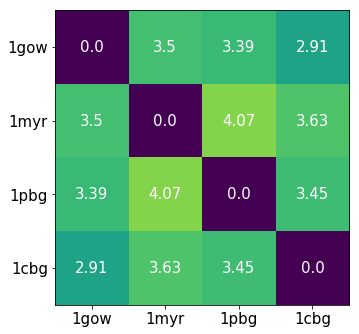

Coverage:


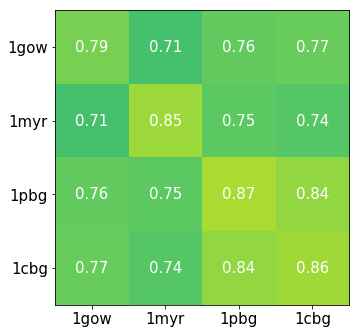

In [60]:
pw_matrix, pw_cov = msa_class.make_pairwise_dtw_rmsd_matrix(dtw_aln)
print("RMSD:")
plot_distance_matrix(pw_matrix, names, 5, 5, 5)
print("Coverage:")
plot_distance_matrix(pw_cov, names, 5, 5, 1)

RMSD:


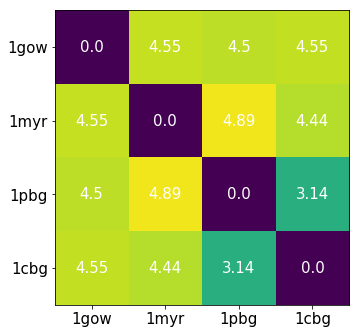

Coverage:


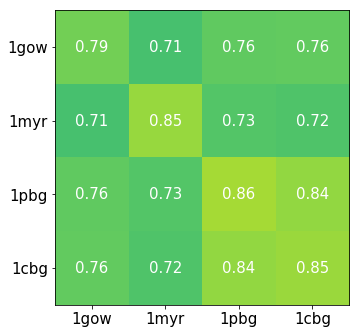

In [61]:
pw_matrix, pw_cov = msa_class.make_pairwise_dtw_rmsd_matrix(seq_aln)
print("RMSD:")
plot_distance_matrix(pw_matrix, names, 5, 5, 5)
print("Coverage:")
plot_distance_matrix(pw_cov, names, 5, 5, 1)

# With Clipping

In [66]:
ref_aln = """1gow      .MYSFPNSFR FGWSQAGFQS EMGTPGSEDP NTDWYKWVHD .PENMAAGLV
1pbg      MTKTLPKDFI FGGATAAYQA EGATHTDGKG PVAWDKYLED NYWYTA....
1cbg      NRSCFAPGFV FGTASSAFQY EGAAFEDGKG PSIWDTFTHK YPEKIK.DRT
1myr      NSSSFEADFI FGVASSAYQI EGT...IGRG LNIWDGFTHR YPDKSGPDHG


1gow      SGDLPENGPG YWGNYKTFHD NAQKMGLKIA RLNSEWSRQF PNPLPRPQNF
1pbg      ..EPASD... FYHKYPVDLE LAEEYGVNGI RISIAWSRIF PTG.......
1cbg      NGDVAID... EYHRYKEDIG IMKDMNLDAY RFSISWPRVL PKG.......
1myr      NGDTTCD... SFSYWQKDID VLDELNATGY RFSIAWSRII PRG.......


1gow      DESKQDVTEV EINENELKRL DEYANKDALN HYREIFKDLK SRGL.YFIQN
1pbg      .......... .......... YGEVNEKGVE FYHKLFAECH KRHVEPFVT.
1cbg      .......... ........KL SGGVNREGIN YYNNLINEVL ANGMQPYVT.
1myr      .......... ........KR SRGVNQKGID YYHGLIDGLI KKGITPFVT.


1gow      MYHWPLPLWL HDPIRVRRGD FTGPSGWLST RTVYEFARFS AYTAWKFDDL
1pbg      LHHFDTPEAL HSN....... ....GDFLNR ENIEHFIDYA AFCFEEFPE.
1cbg      LFHWDVPQAL EDEYR..... .....GFLGR NIVDDFRDYA ELCFKEFGDR
1myr      LFHWDLPQTL QDEYE..... .....GFLDP QIIDDFKDYA DLCFEEFGDS


1gow      VDEYSTMNEP NVVGGLGYVG VKSGFPPGYL SF........ ....ELSRRA
1pbg      VNYWTTFNEI GPIGDGQYLV GK..FPPG.I KY........ ..DLAKVFQS
1cbg      VKHWITLNEP WGVSMNAYAY GT..FAPGRC SDWLKLNCTG GDSGREPYLA
1myr      VKYWLTINQL YSVPTRGYGS AL..DAPGRC SPTVDPSCYA GNSSTEPYIV


1gow      MYNIIQ...A HARAYDGIKS VSK...KPVG IIYANS...S FQPLTDK...
1pbg      HHNMMV...S HARAVKLYKD KGYK..GEIG VVHALPTKYP YDPENPA...
1cbg      AHYQLLAHAA AARLYKTKYQ ASQN..GIIG ITLVSH...W FEPAS.KEKA
1myr      AHHQLL...A HAKVVDLYRK NYTHQGGKIG PTMITR...W FLPYNDTDRH


1gow      DMEAVEMAEN DNRWWFFDAI IRGEITRGNE KIVRDDLK.. ..........
1pbg      DVRAAELEDI IHNKFILDAT YLGHYSDKTM EGVNHILAEN GGELDLRDED
1cbg      DVDAAKRGLD FMLGWFMHPL TKGRYPESMR YLVRKRLPK. .....FSTEE
1myr      SIAATERMKQ FFLGWFMGPL TNGTYPQIMI DTVGARLPT. .....FSPEE


1gow      ........GR LDWIGVNYYT RTVVKRTEK. .......GYV SLGGYGHG..
1pbg      FQALDAAKDL NDFLGINYYM SDWMQAFD.. .......GET EIIKYQIK..
1cbg      SKELT...GS FDFLGLNYYS SYYAAKAPRI PNARP.AIQT DSLINATF.E
1myr      TNLVK...GS YDFLGLNYYF TQYAQPSPNP VNATNHTAMM DAGAKLTYIN


1gow      CERNSVSLAG LPTSDFG... WEFFPEGLYD VLTKYWNRYH L..YMYVTEN
1pbg      GVGRRVAPDY VPR....... WIIYPEGLYD QIMRVKNDYP NYKKIYITEN
1cbg      HNGKPLGPMA ASS......W LCIYPQGIRK LLLYVKNHYN NP.VIYITEN
1myr      ASGHYIGPLF ESDGGDGSSN IYYYPKGIYS VMDYFKNKYY NP.LIYVTEN


1gow      GIADDA.... .......DYQ RPYYLVSHVY QVHRAINS.G ADVRGYLHWS
1pbg      GLGYKDE... FVDNTVYDDG RIDYVKQHLE VLSDAIAD.G ANVKGYFIWS
1cbg      GRNEFNDPTL SLQESLLDTP RIDYYYRHLY YVLTAIGD.G VNVKGYFAWS
1myr      GISTPGSE.. NRKESMLDYT RIDYLCSHLC FLNKVIKEKD VNVKGYLAWA


1gow      LADNYEWASG FSMRFGLLKV DY.NTKRLYW RPSALVYREI ATNG
1pbg      LMDVFSWSNG YEKRYGLFYV DF.DTQERYP KKSAHWYKKL AETQ
1cbg      LFDNMEWDSG YTVRFGLVFV DFKNNLKRHP KLSAHWFKSF LKK.
1myr      LGDNYEFNNG FTVRFGLSYI NWNNVTDRDL KKSGQWYQKF ISP."""

In [67]:
ref_aln_dict = defaultdict(list)
for line in ref_aln.split('\n'):
    line = line.strip().replace('.', '-')
    if len(line.strip()):
        parts = line.split('      ')
        ref_aln_dict[parts[0]] += parts[1].split()

ref_aln_dict = {k: ''.join(ref_aln_dict[k]) for k in ref_aln_dict}

In [68]:
structures = benchmark_paper.get_structures(pdb_dir)
names = [s.name for s in structures]

In [69]:
clip_indices = {}
for i, n in enumerate(names):
    start = structures[i].sequence.find(ref_aln_dict[n].replace('-', ''))
    clip_indices[n] = (start, start+len(ref_aln_dict[n].replace('-', '')))

In [82]:
clip_indices

{'1cbg': (14, 490), '1gow': (0, 469), '1myr': (18, 499), '1pbg': (0, 451)}

In [71]:
structures_clipped = [psa.Structure(s.name, 
                                    s.sequence[clip_indices[s.name][0]: clip_indices[s.name][1]],
                                    s.coords[clip_indices[s.name][0]: clip_indices[s.name][1], :]) for s in structures]

In [73]:
seq_aln_clipped = benchmark_paper.get_sequence_alignment({s.name: s.sequence for s in structures_clipped}, sequence_dir, f"{name}_clipped")

In [100]:
msa_class_clipped = msa.StructureMultiple(structures_clipped)
dtw_aln_clipped = msa_class_clipped.align(seq_aln_clipped, gap_open_penalty=5, gap_extend_penalty=1.5)

RMSD:


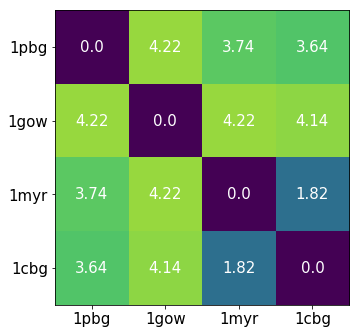

Coverage:


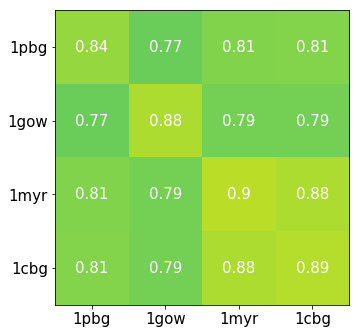

In [101]:
pw_matrix, pw_cov = msa_class_clipped.make_pairwise_dtw_rmsd_matrix(dtw_aln_clipped)
print("RMSD:")
plot_distance_matrix(pw_matrix, names, 5, 5, 5)
print("Coverage:")
plot_distance_matrix(pw_cov, names, 5, 5, 1)

RMSD:


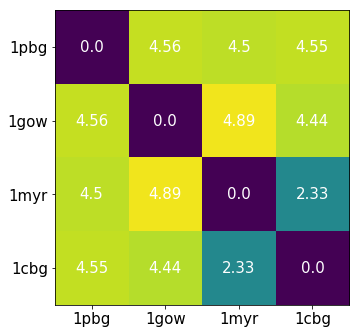

Coverage:


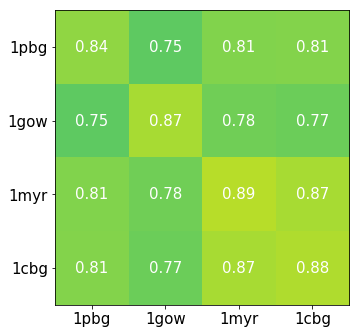

In [94]:
pw_matrix, pw_cov = msa_class_clipped.make_pairwise_dtw_rmsd_matrix(seq_aln_clipped)
print("RMSD:")
plot_distance_matrix(pw_matrix, names, 5, 5, 5)
print("Coverage:")
plot_distance_matrix(pw_cov, names, 5, 5, 1)

RMSD:


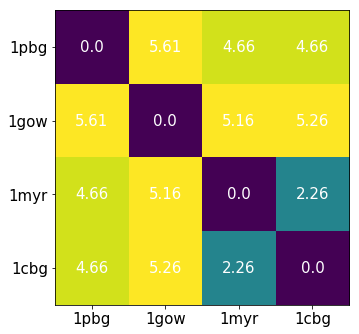

Coverage:


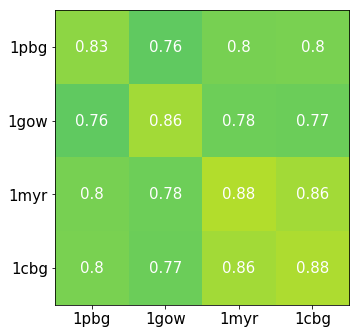

In [95]:
pw_matrix, pw_cov = msa_class_clipped.make_pairwise_dtw_rmsd_matrix(ref_aln_dict)
print("RMSD:")
plot_distance_matrix(pw_matrix, names, 5, 5, 5)
print("Coverage:")
plot_distance_matrix(pw_cov, names, 5, 5, 1)

# Extracting features

In [105]:
from caretta import feature_extraction, helper

In [103]:
pdbs = benchmark_paper.get_pdbs(pdb_dir)

In [122]:
gnm_cbs = {n: feature_extraction.get_gnm_fluctuations(pdbs[n][helper.get_beta_indices(pdbs[n])]) for n in pdbs}

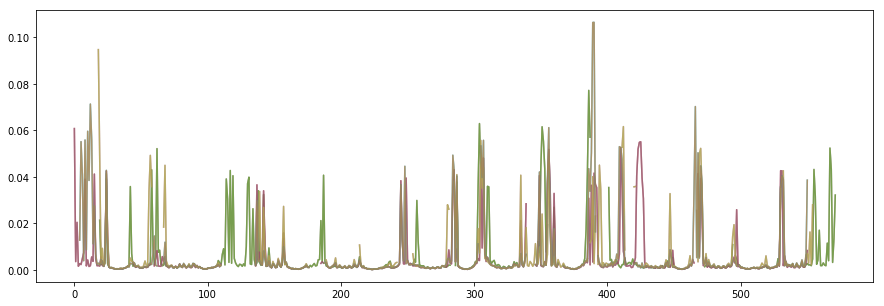

In [123]:
gnm_cbs_dtw_aligned = {n: helper.get_aligned_data(helper.aligned_string_to_array(dtw_aln[n]), gnm_cbs[n].reshape(-1,1)) for n in names}

plt.figure(figsize=(15, 5))
for n in names:
    plt.plot(gnm_cbs_dtw_aligned[n], alpha=0.5)

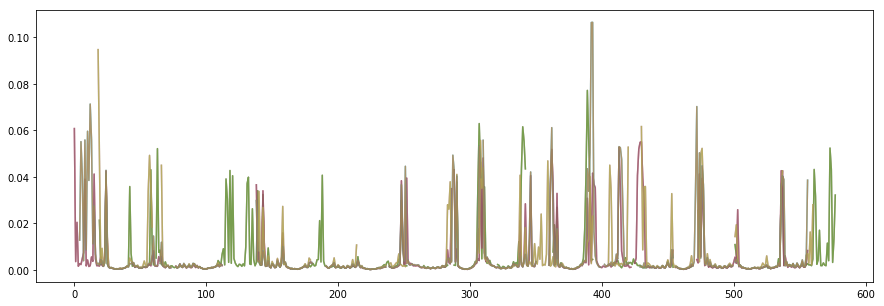

In [124]:
gnm_cbs_seq_aligned = {n: helper.get_aligned_data(helper.aligned_string_to_array(seq_aln[n]), gnm_cbs[n].reshape(-1,1)) for n in names}

plt.figure(figsize=(15, 5))
for n in names:
    plt.plot(gnm_cbs_seq_aligned[n], alpha=0.5)

In [126]:
dssp_dir = data_dir / "dssp_data"
if not dssp_dir.is_dir():
    dssp_dir.mkdir()

In [127]:
dssp_features = {n: feature_extraction.get_dssp_features(pdbs[n], sequence_dir / f"{n}.pdb", dssp_dir) for n in names}

In [136]:
dssp_features[names[0]].keys()

dict_keys(['dssp_NH_O_1_energy', 'dssp_NH_O_1_index', 'dssp_NH_O_2_energy', 'dssp_NH_O_2_index', 'dssp_O_NH_1_energy', 'dssp_O_NH_1_index', 'dssp_O_NH_2_energy', 'dssp_O_NH_2_index', 'dssp_acc', 'dssp_alpha', 'dssp_kappa', 'dssp_phi', 'dssp_psi', 'dssp_tco'])

In [138]:
feature_name = "dssp_phi"

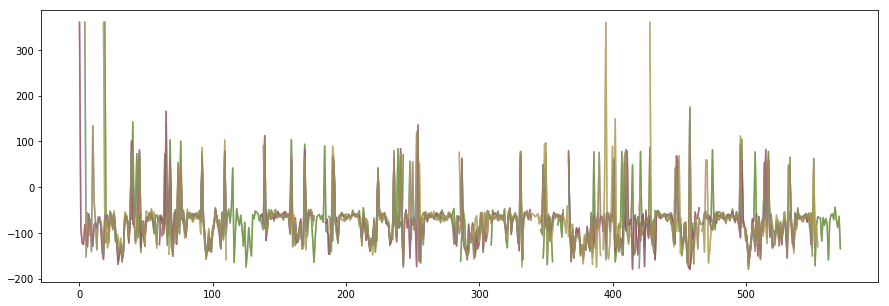

In [139]:
feature_dtw_aligned = {n: helper.get_aligned_data(helper.aligned_string_to_array(dtw_aln[n]), dssp_features[n][feature_name].reshape(-1,1)) for n in names}

plt.figure(figsize=(15, 5))
for n in names:
    plt.plot(feature_dtw_aligned[n], alpha=0.5)

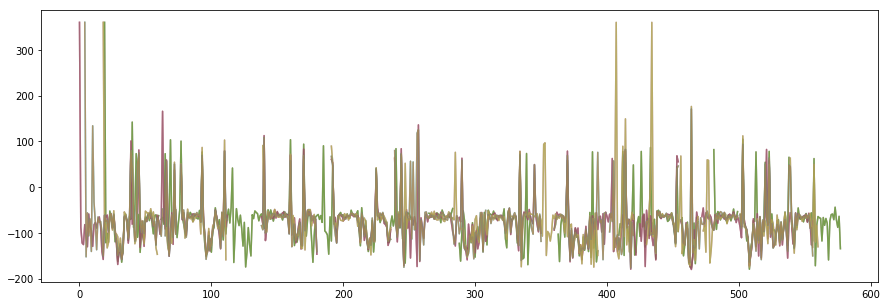

In [140]:
feature_seq_aligned = {n: helper.get_aligned_data(helper.aligned_string_to_array(seq_aln[n]), dssp_features[n][feature_name].reshape(-1,1)) for n in names}

plt.figure(figsize=(15, 5))
for n in names:
    plt.plot(feature_seq_aligned[n], alpha=0.5)

**Looks like phi/psi angles can be used for initial alignment instead of sequence!**

# Looking at Structure Variation

In [162]:
print("Adjacency list (according to structure index in msa_class)")
msa_class.tree

Adjacency list (according to structure index in msa_class)


array([[1, 4],
       [2, 4],
       [0, 5],
       [3, 5],
       [4, 5]], dtype=uint64)

In [143]:
print("Branch lengths")
msa_class.branch_lengths

Branch lengths


array([[ 2.79473024],
       [ 1.2769976 ],
       [ 1.39277112],
       [ 1.51343776],
       [ 0.16493266]])

Original structures are 0,1,2,3. Intermediate nodes are 4 and 5. Mean of all structures is always the last index (index 5)

In [144]:
mean_coords = msa_class.structures[-1].coords

In [158]:
aln_coords = np.zeros((len(names), len(dtw_aln[names[0]]), 3))
for i, name in enumerate(names):
    aln_coords[i] = helper.get_aligned_data(helper.aligned_string_to_array(dtw_aln[name]), msa_class.structures[i].coords)

In [159]:
std_coords = np.std(aln_coords, axis=0)
std_coords_summary = np.mean(std_coords, axis=1)

In [160]:
import plotly.offline as ply
import plotly.graph_objs as go
ply.init_notebook_mode(True)

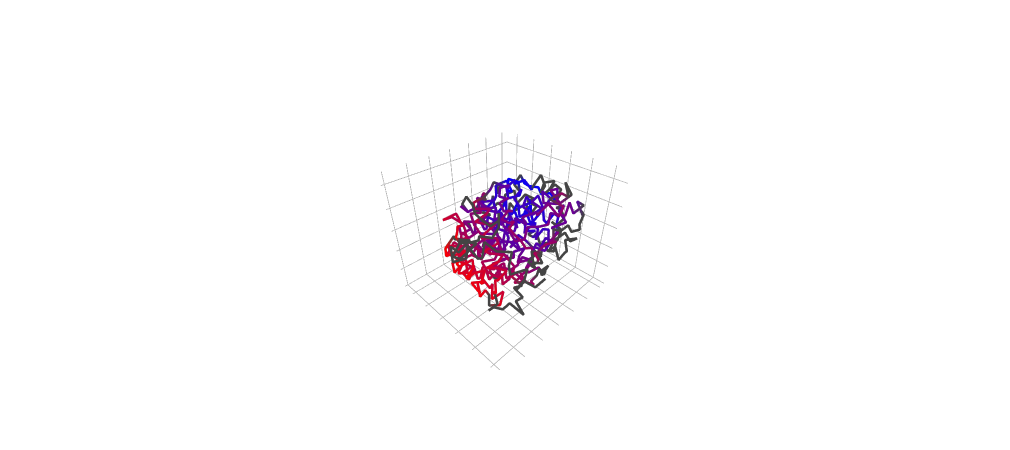

In [161]:
ply.iplot(go.Figure(data=[go.Scatter3d(x=mean_coords[:,0], y=mean_coords[:, 1], z=mean_coords[:, 2],
                                   mode='lines', line=dict(
        color=std_coords_summary,
        colorscale='Bluered',
        width=5,
    ))]))